In [2]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import numpy as np
import os
import nrrd
import pytorch_lightning as pl #python -m pip install lightning
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, Lambda, RandSpatialCrop, RandRotate90, ToTensor
from monai.networks.nets import AutoEncoder
#from monai.losses import DiceLoss
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import time

In [3]:
class SlicePlotter:
    def __init__(self):
        pass

    def plot_slices(self, original_slice, reconstruction_slice, title):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title(f'Original {title} Slice')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstruction_slice, cmap='gray')
        plt.title(f'Reconstructed {title} Slice')
        plt.show()

class VolumePlotter:
    def __init__(self):
        self.color_map = np.array([
            [0, 0, 0, 0],      # Transparent for background (0)
            [255, 0, 0, 255],  # Red for arteries (1)
            [0, 0, 255, 255]   # Blue for veins (2)
        ], dtype=np.uint8)
        self.downsample_factor = 2

    def plot_volumes(self, original_volume, reconstruction_volume, title):
        # Downsample original volume
        original_volume_downsampled = original_volume[::self.downsample_factor, 
                                                       ::self.downsample_factor, 
                                                       ::self.downsample_factor]

        # Downsample reconstructed volume
        reconstruction_volume_downsampled = reconstruction_volume[::self.downsample_factor, 
                                                                   ::self.downsample_factor, 
                                                                   ::self.downsample_factor]

        # Downsample color map along the first axis to match the number of unique values in the downsampled volume
        color_map_downsampled = self.color_map[:len(np.unique(original_volume_downsampled))]

        # Plot original and reconstructed volumes with titles using Matplotlib
        fig = plt.figure(figsize=(10, 5))

        # Plot original volume with assigned colors and no edge color
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.set_title(f'Original {title} Volume')

        # Define colors for each voxel value in the original volume using the downsampled color map
        original_colors = np.take(color_map_downsampled, original_volume_downsampled, axis=0) / 255.0
        ax1.voxels(original_volume_downsampled, facecolors=original_colors)

        # Plot reconstructed volume with assigned colors and no edge color
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.set_title(f'Reconstructed {title} Volume (With Noise)')

        # Define colors for each voxel value in the reconstructed volume using the downsampled color map
        reconstruction_colors = np.take(color_map_downsampled, reconstruction_volume_downsampled, axis=0) / 255.0
        ax2.voxels(reconstruction_volume_downsampled, facecolors=reconstruction_colors)

        plt.show()

class AutoEncoderModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.autoencoder = AutoEncoder(
            spatial_dims=3, 
            in_channels=1, 
            out_channels=3,  # Output channels set to 3
            channels=(16, 32, 64, 128, 4), 
            strides=(2, 2, 2, 2, 2), 
            kernel_size=3, 
            num_res_units=2
        )
        # Define class weights
        class_weights = torch.tensor([0.2, 0.4, 0.4])
        self.loss_function = nn.CrossEntropyLoss(weight=class_weights)
        self.volume_plotter = VolumePlotter()  # Instantiate VolumePlotter

    def forward(self, x):
        return self.autoencoder(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x_hat = self(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())
        self.log('train_loss', loss)

        if (self.current_epoch) % 300 == 0 and batch_idx == 0:
            original_volume = x[0, 0, :, :, :].detach().cpu().numpy().astype(int)  
            reconstruction_volume = np.argmax(x_hat[0,:,:,:,:].detach().cpu().numpy(), axis=0)
            self.volume_plotter.plot_volumes(original_volume, reconstruction_volume, 'Train')

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        x_hat = self(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())
        self.log('val_loss', loss, prog_bar=True)

        if (self.current_epoch) % 300 == 0 and batch_idx == 0:
            original_volume = x[0, 0, :, :, :].detach().cpu().numpy().astype(int)  
            reconstruction_volume = np.argmax(x_hat[0,:,:,:,:].detach().cpu().numpy(), axis=0)
            self.volume_plotter.plot_volumes(original_volume, reconstruction_volume, 'Val')
            torch.save(model.state_dict(), folder_path + '/autoencoder.pth')

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nrrd')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data, header = nrrd.read(file_path)
        if self.transform:
            data = self.transform(data)
        return data, data

# Define a custom callback to plot both training and validation losses

class PlotLossCallback(pl.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.log_dir = log_dir

    def on_train_start(self, trainer, pl_module):
        # Clear previous graphs
        #tf.compat.v1.reset_default_graph()
        self.writer = SummaryWriter(self.log_dir)

    def on_train_epoch_end(self, trainer, pl_module, **kwargs):
        epoch = trainer.current_epoch
        train_loss = trainer.callback_metrics['train_loss'].cpu().item()
        val_loss = trainer.callback_metrics['val_loss'].cpu().item()

        # Write both training and validation loss to the same graph with epoch as global step
        self.writer.add_scalars('MAE Job 17 Loss', {'training' : train_loss, 
                                                   'validation' : val_loss }, global_step=epoch +1 )
        time_spent = time.time() - start_time
        print(f"Time Spent {time_spent:.2f}")
    def on_train_end(self, trainer, pl_module):
        self.writer.close()

transform = Compose([
    Lambda(func=lambda x: np.expand_dims(x, 0) if x.ndim == 3 else x),
    RandSpatialCrop((256, 256, 256), random_size=False),
    RandRotate90(prob=0.5),
    ToTensor(dtype=torch.float32)
])

device = torch.device("cuda" if torch.cuda.is_available() else "gpu")


Input image shape: torch.Size([1, 1, 256, 256, 256])
Encoded Rep shape: torch.Size([1, 4, 8, 8, 8])
Intermediate shape: torch.Size([1, 4, 8, 8, 8])
Noise image shape: torch.Size([1, 4, 8, 8, 8])
Full Reconstructed image shape: torch.Size([1, 3, 256, 256, 256])
Reconstructed Image shape: torch.Size([1, 3, 256, 256, 256])
Original volume shape: (256, 256, 256)
Reconstructed volume shape: (256, 256, 256)


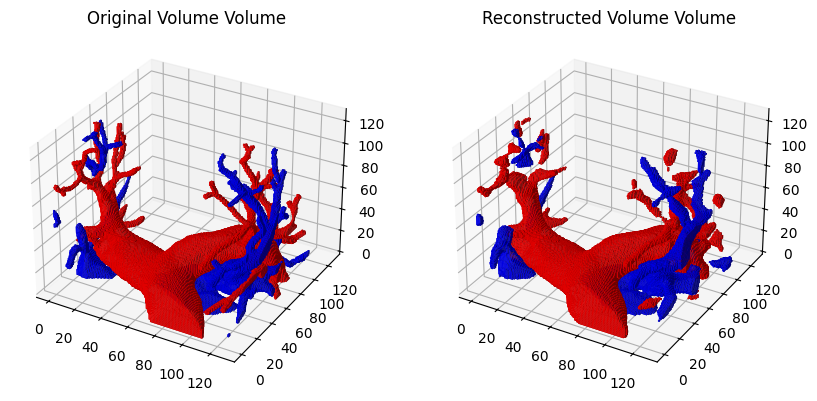

In [4]:
# Load the pre-trained autoencoder model
model_dir = "Z:/RA4/jobs/Mask AutoEcoder Jobs/MAEjob17/Models/ae1.pth"

# Load the pre-trained model
model = AutoEncoderModel()
model.load_state_dict(torch.load(model_dir))
model.eval()

# Define a function to add noise to the input image
def add_noise(input_image, noise_level):
    noise = torch.randn_like(input_image) * noise_level
    return input_image + noise

# Define a function to get the bottleneck information
def get_bottleneck_info(input_image):
    with torch.no_grad():
        output = model.autoencoder(input_image.unsqueeze(0))
    return output[-1]

data_dir = "./mask70debug"
dataset = MyDataset(data_dir, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

# Initialize VolumePlotter
volume_plotter = VolumePlotter()

# Iterate over the data loader
for input_image, _ in dataloader:
    print("Input image shape:", input_image.shape)
    # Add noise to the input image
    encoded_representation = model.autoencoder.encode(input_image)
    print("Encoded Rep shape:", encoded_representation.shape)

     # Pass through the intermediate module
    intermediate_output = model.autoencoder.intermediate(encoded_representation)
    print("Intermediate shape:", intermediate_output.shape)  

    noisy_image = add_noise(intermediate_output, noise_level=0.1)  # Adjust noise level as needed
    print("Noise image shape:", noisy_image.shape)
    # Pass the noisy image through the second half of the model
    with torch.no_grad():
        reconstructed_image = model.autoencoder.decode(noisy_image)
        reconstructed_image_full = model(input_image)

    # Access the reconstructed image dimensions
    print("Full Reconstructed image shape:", reconstructed_image_full.shape)

    # Access reconstructed image if needed
    #reconstructed_image = reconstructed_image.squeeze(0)
    print("Reconstructed Image shape:", reconstructed_image.shape)
    # Convert tensors to numpy arrays
    original_volume = input_image[0, 0, :, :, :].detach().cpu().numpy().astype(int)  
    reconstruction_volume = np.argmax(reconstructed_image[0,:,:,:,:].detach().cpu().numpy(), axis=0)
    #original_volume = input_image.squeeze().numpy().astype(int)
    #reconstruction_volume = reconstructed_image.numpy().astype(int)

    print("Original volume shape:", original_volume.shape)
    print("Reconstructed volume shape (With Noise):", reconstruction_volume.shape)
    
    # Plot volumes
    model.volume_plotter.plot_volumes(original_volume, reconstruction_volume, 'Volume')

In [6]:
# Load the pre-trained autoencoder model
model_dir = "Z:/RA4/jobs/Mask AutoEcoder Jobs/MAEjob17/Models/ae1.pth"

# Load the pre-trained model
model = AutoEncoderModel()
model.load_state_dict(torch.load(model_dir))
model.eval()

# Define a function to add noise to the input image
def add_noise(input_image, noise_level):
    noise = torch.randn_like(input_image) * noise_level
    return input_image + noise

# Define a function to get the bottleneck information
def get_bottleneck_info(input_image):
    with torch.no_grad():
        output = model.autoencoder(input_image.unsqueeze(0))
    return output[-1]

data_dir = "./mask70debug"
dataset = MyDataset(data_dir, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

# Initialize VolumePlotter
volume_plotter = VolumePlotter()

# Iterate over the data loader
for input_image, _ in dataloader:
    print("Input image shape:", input_image.shape)
    # Add noise to the input image
    encoded_representation = model.autoencoder.encode(input_image)
    print("Encoded Rep shape:", encoded_representation.shape)

     # Pass through the intermediate module
    intermediate_output = model.autoencoder.intermediate(encoded_representation)
    print("Intermediate shape:", intermediate_output.shape)  

    noisy_image = add_noise(intermediate_output, noise_level=0.2)  # Adjust noise level as needed
    print("Noise image shape:", noisy_image.shape)
    # Pass the noisy image through the second half of the model
    with torch.no_grad():
        reconstructed_image = model.autoencoder.decode(noisy_image)
        reconstructed_image_full = model(input_image)

    # Access the reconstructed image dimensions
    print("Full Reconstructed image shape:", reconstructed_image_full.shape)

    # Access reconstructed image if needed
    #reconstructed_image = reconstructed_image.squeeze(0)
    print("Reconstructed Image shape:", reconstructed_image.shape)
    # Convert tensors to numpy arrays
    original_volume = input_image[0, 0, :, :, :].detach().cpu().numpy().astype(int)  
    reconstruction_volume = np.argmax(reconstructed_image[0,:,:,:,:].detach().cpu().numpy(), axis=0)
    #original_volume = input_image.squeeze().numpy().astype(int)
    #reconstruction_volume = reconstructed_image.numpy().astype(int)

    print("Original volume shape:", original_volume.shape)
    print("Reconstructed volume shape (With Noise):", reconstruction_volume.shape)
    
    # Plot volumes
    model.volume_plotter.plot_volumes(original_volume, reconstruction_volume, 'Volume')

Input image shape: torch.Size([1, 1, 256, 256, 256])
Encoded Rep shape: torch.Size([1, 4, 8, 8, 8])
Intermediate shape: torch.Size([1, 4, 8, 8, 8])
Noise image shape: torch.Size([1, 4, 8, 8, 8])
Full Reconstructed image shape: torch.Size([1, 3, 256, 256, 256])
Reconstructed Image shape: torch.Size([1, 3, 256, 256, 256])
Original volume shape: (256, 256, 256)
Reconstructed volume shape (With Noise): (256, 256, 256)
